# Variational Autoencoders (VAE)


- Kingma, D. & Welling, M. (2013). Auto-Encoding Variational Bayes ([arxiv](https://arxiv.org/abs/1312.6114))  
- Tomczak, J.M. (2022). Deep Generative Modeling, Section 5.3 ([springer](https://link.springer.com/book/10.1007/978-3-030-93158-2))


## Theory

Consider an image, $x$. We say that $x$ has been generated from some latent variable $z$ via some non-linear function parameterised by $\theta$, written as $p_\theta(x|z)$. For each possible latent $z$, the function $p_\theta(x|z)$ specifies the distribution over all images that could be generated. If we could learn those parameters, i.e. $\theta$, then for any chosen latent variable $z$, we could generate new images from sampling from this distribution. 

However, we don't know how $z$ is distributed, nor do we know the parameters. To begin, we can assume that $z$ is drawn from a standard Gaussian distribution, $z\sim\mathcal{N}(0,I)$ - we do this because it gives us a mathematically convenient space to sample from. Then, to learn the parameters, we can take a dataset of real images and find parameters $\theta$ such that when we draw the latent variable $z\sim\mathcal{N}(0,I)$ then generate images through $p_\theta(x|z)$, the resulting samples resemble the data we actually observe. To do this, we would like to **maximise the likelihood** of seeing the real data given our model. For a single image, this likelihood, $p_\theta(x)$, is given by:
$$p_\theta(x)=\int p_\theta(x|z)\cdot p(z) dz$$
In plain English, this says that to explain an image $x$, we must consider **all possible latent variables $z$** that could have generated it, weighed by how likely each individual $z$ is under the prior distribution (i.e., the unit Gaussian). 

### Monte Carlo Approximation
In Factor Analysis, where the mapping is linear ($x=\mu+Wz+\epsilon$), this integral can be solved analytically: both the prior over $z$ and the conditional distribution $x|z$ are Gaussian, and linear transformation of a Gaussian is still Gaussian. However, in the VAE, $p_\theta(x|z)$ depends on a complicated non-linear function of $z$. This means that $x|z$ is no longer Gaussian, and the integral over all possible $z$ has no closed form solution. As a result, computing $p_\theta(x)$ directly is intractable. What can we do instead?

In principle, we could approximate the likelihood by sampling $z$, evaluating the likelihood of seeing $x$ given $z$ under the current parameters ($p_\theta(x|z)$), and then averaging across many values of $z$ (Monte Carlo technique): $$p_\theta(x)=\frac{1}{N}\sum_{n=1}^N p_\theta(x|z^{(n)}), \quad z^{(n)}\sim\mathcal{N}(0,I)$$ 
However, most samples $z$ drawn from $\mathcal{N}(0,I)$ will be poor at explaining a particular image $x$ - only a tiny fraction of samples will actually be viable for generating $x$, leading to high variance as many $p_\theta(x|z)$ will be nearly zero. As the dimensionality of $z$ grows, this makes it even less likely that randomly drawn $z$ values will explain the particular image, and so variance explodes with dimensionality. In practice, we'd need to compute this approximation separately for every single datapoint in the dataset at every single training step - so this approach isn't viable. 

### Variational Inference

What if we could instead sample viable values of $z$ *given* $x$, and then use only those in our approximation? Instead of sampling $z$ blindly from the prior, $\mathcal{N}(0,I)$, we'd instead sample from the *posterior* $p_\theta(z|x)$, which is already concentrated in the viable regions of latent space for that datapoint. This would make our Monte Carlo approximation much more efficient, since we'd only be using values of $z$ that actually explain $x$. How do we get the posterior? Let's take a look at Bayes' rule:
$$p_\theta(z|x)=\frac{p_\theta(x|z)\cdot p(z)}{p_\theta(x)}$$
We can evaluate $p_\theta(x|z)$, and we also know $p(z)$ because $z\sim\mathcal{N}(0,I)$ - but we've just seen that the denominator, $p_\theta(x)$, is intractable.

Instead, we can take an approach called **variational inference**. This means picking a family of simple, tractable distributions (e.g., Gaussians) and introducing a distribution $q_\phi(z|x)$ that *approximates* the true posterior $p_\theta(z|x)$ by adjusting its parameters $\phi$:
$$q_\phi(z|x)\approx p_\theta(z|x)$$
We already have $x$ (our data), but we need to learn the parameters $\phi$. We want $q_\phi(z|x)$ to be as *close* as possible to the true posterior - this gives us a concrete objective. We can measure 'closeness' (statistical distance) between two continuous probability distributions over the same variable using the **Kullback-Leibler (KL) divergence**:
$$D_{KL}(p||q)\doteq\int p(x)\log\frac{p(x)}{q(x)}$$
In other words, we want to minimise:
$$KL\left(q_\phi(z|x)||p_\theta(z|x)\right)$$
However - $p_\theta(z|x)=\frac{p_\theta(x|z)\cdot p(z)}{p_\theta(x)}$, and $p(x)$ is intractable. We need another approach.



### Deriving ELBO
Let's substitute in our distributions to the equation for $D_{KL}$ above:
$$
KL\left(q_\phi(z|x)||p_\theta(z|x)\right) = \int q_\phi(z|x) \cdot \log \frac{q_\phi(z|x)}{p_\theta(z|x)}$$

Rewritten in expectation notation: 
$$
KL\left(q_\phi(z|x)||p_\theta(z|x)\right) = \mathbb{E}_{q_\phi}\left[\log\frac{q_\phi(z|x)}{p_\theta(z|x)}\right]
$$

Using log identities:
$$KL\left(q_\phi(z|x)||p_\theta(z|x)\right) = \mathbb{E}_{q_\phi}\left[\log q_\phi(z|x) - \log p_\theta(z|x)\right]$$

Using Bayes' rule to rewrite $\log p_\theta(z|x)=\log p_\theta(x|z)+\log p(z) - \log p_\theta(x)$ and substituting in:
$$KL\left(q_\phi(z|x)||p_\theta(z|x)\right) = \mathbb{E}_{q_\phi}\left[\log q_\phi(z|x) - \log p_\theta(x|z) - \log p(z) + \log p_\theta(x) \right]$$

We can then remove $p_\theta(x)$ from the expectation because it is constant w.r.t $z$ (i.e., changing $z$ doesn't change $x$):
$$KL\left(q_\phi(z|x)||p_\theta(z|x)\right) = \mathbb{E}_{q_\phi}\left[\log q_\phi(z|x) - \log p_\theta(x|z) - \log p(z)\right] + \log p_\theta(x)$$

And then solving for $\log p_\theta(x)$ by subtracting the expectation term from both sides:
$$\log p_\theta(x) = KL\left(q_\phi(z|x)||p_\theta(z|x)\right) - \mathbb{E}_{q_\phi}\left[\log q_\phi(z|x) - \log p_\theta(x|z) - \log p(z)\right] $$

Recalling that expectation is linear (i.e., $\mathbb{E}[A-B-C]=\mathbb{E}[A]-\mathbb{E}[B]-\mathbb{E}[C]$), we can rewrite:
$$\log p_\theta(x) = KL\left(q_\phi(z|x)||p_\theta(z|x)\right) - \mathbb{E}_{q_\phi}[\log q_\phi(z|x)] + \mathbb{E}_{q_\phi}[\log p_\theta(x|z)] + \mathbb{E}_{q_\phi}[\log p(z)]$$

And that the KL divergence between two distributions of the same variable is $KL(q||p)=\mathbb{E}_q[\log q - \log p]$ - we can group $-\mathbb{E}_{q_\phi}[\log q_\phi(z|x)]$ and $\mathbb{E}_{q_\phi}[\log p(z)]$ as: $$KL\left(q_\phi(z|x)||p(z)\right)$$
To yield:
$$\log p_\theta(x) = KL\left(q_\phi(z|x)||p_\theta(z|x)\right) + \mathbb{E}_{q_\phi}[\log p_\theta(x|z)] - KL\left(q_\phi(z|x)||p(z)\right)$$

Now we have $\log p_\theta(x)$ as a function of three meaningful quantities: 
- the divergence between the approximate posterior and the true posterior, $KL\left(q_\phi(z|x)||p_\theta(z|x)\right)$;
- the divergence between the approximate posterior and the prior, $KL\left(q_\phi(z|x)||p(z)\right)$;
- and the expected log-likelihood of the data given the latents, $\mathbb{E}_{q_\phi}[\log p_\theta(x|z)]$, which measures how well samples of $z$ explain the observed $x$. 

Take special note of the term $KL\left(q_\phi(z|x)||p_\theta(z|x)\right)$: though it's intractable, we do know that this quantity is **always $\geq 0$** - it's zero if $q_\phi(z|x)=p_\theta(z|x)$, and greater otherwise. 

This means that the other two terms **must always be less than or equal to $\log p_\theta(x)$**:
- If $q_\phi(z|x)=p_\theta(z|x)$, then $$\log p_\theta(x)=\mathbb{E}_{q_\phi}[\log p_\theta(x|z)] - KL\left(q_\phi(z|x)||p(z)\right)$$ 
- If $q_\phi(z|x)\neq p_\theta(z|x)$, then $$\log p_\theta(x)>\mathbb{E}_{q_\phi}[\log p_\theta(x|z)] - KL\left(q_\phi(z|x)||p(z)\right)$$

These two terms are referred to as the **Evidence Lower Bound (ELBO)**, simply because they put a lower bound on the log-likelihood. This means that even though we **can't evaluate** the posterior KL, we **can evaluate** these two terms and use them as a proxy objective: by maximising the ELBO, we also push up the log-likelihood. 
$$\text{ELBO}\doteq
\underbrace{\mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]}_{\text{reconstruction term}}
- 
\underbrace{KL\left(q_\phi(z|x)||p(z)\right)}_{\text{regulariser}}**
$$

The two terms perform two distinct roles:
- **Reconstruction term**: encourages the model to reconstruct the input well by maximising the log-likelihood of the data given the latent.
- **Regulariser**: forces the model to keep its latents close to the prior distribution - this means that we can sample from the prior $p(z)$ to generate new images.


### Learning

This leaves us three terms to evaluate:
- **$q_\phi(z|x)$**: The approximate posterior. We select a tractable distribution then fit the parameters $\phi$. 
- **$p(z)$**: The prior over latents. We pick a simple distribution like $p(z)=\mathcal{N}(0,I)$.
- **$\mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]$**: The expected log-likelihood of reconstructing $x$ given latents drawn from $q_\phi(z|x)$. We approximate this expectation via the Monte Carlo approach outlined earlier - sample $z\sim q_\phi(z|x)$, compute $\log p_\theta(x|z)$, then average over samples.

This leaves us a very tractable function that we can optimise. We want to maximise the objective function $\mathcal{L}$ (equivalently minimise $-\mathcal{L}$):
$$
\mathcal{L} = \text{ELBO} = \mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]-KL\left(q_\phi(z|x)||p(z)\right)
$$
We just need to fit the parameters, $\theta$ and $\phi$, using gradient descent. Let's consider how we would do that.

#### $\theta$
$\theta$ appears only in $\log p_\theta(x|z)$. For a sample $z\sim q_\phi(z|x)$, the gradient of $\mathcal{L}$ is given by:
$$\nabla_\theta \mathcal{L}=\mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]$$

For a Gaussian distribution, $\log p_\theta(x|z)=\mathcal{N}(x;\mu_\theta(z), \text{diag}(\sigma^2_\theta(z)))$, which, equivalently, is:
$$\log p_\theta(x|z)=-\frac{1}{2}\sum_i\left[\log(2\pi\sigma^2_i)+\frac{(x_i-\mu_i)^2}{\sigma_i^2}\right]$$
through which we can trivially backpropagate through $\mu_\theta(z)$ and $\sigma_\theta(z)$ to calculate their gradients w.r.t $\mathcal{L}$.

#### $\phi$
$\phi$ appears twice:
1. Inside the KL to the prior, $KL\left(q_\phi(z|x)||p(z)\right)$. For a Gaussian $q_\phi=\mathcal{N}(\mu_\phi, \text{diag}(\sigma_\phi^2))$ and $p(z)=\mathcal{N}(0,I)$, this KL yields the closed form: $$KL=\frac{1}{2}\sum_{j=1}^d (\mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1)$$
And so we can obtain the gradient of $\phi$ w.r.t. $KL$, $\nabla_\phi KL$, by backpropagating through $\mu_\phi(x)$ and $\sigma_\phi(x)$.
  
2. Inside the expectation, $\mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]$, because $z\sim q_\phi(z|x)$, so we want to find the gradient of $\phi$ w.r.t. the expectation: $$\nabla_\phi\int q_\phi(z|x)\cdot \log p_\theta(x|z)dz$$
However - observe that $z$ is sampled from $q_\phi(z|x)$ which itself depends on $\phi$. Gradients cannot flow through this step, because the act of sampling breaks the computational graph. This means that while we *can* calculate the gradients of operations downstream of (after) a sampling process (as we did with $\theta$), we *cannot* calculate the gradient of anything upstream (before), with respect to the parameters of the distribution that generated the sample. We'll need to consider an alternative approach.

### Reparameterisation Trick
We have observed how the reconstruction term's gradient w.r.t. $\phi$ is blocked by the sampling step. The problem arises from:
$$z\sim q_\phi(z|x)$$
What if we could instead separate the randomness from the parameters $\phi$? Instead of sampling $z$ directly from $q_\phi(z|x)$, where $q$ is a chosen family of tractable distributions, we can instead use the learned parameters to describe a deterministic, linear transformation of a noise drawn from a separate distribution of the same family.

For example, if we assume that the posterior is Gaussian:
$$q_\phi(z|x)=\mathcal{N}(z;\mu_\phi(x), \text{diag }\sigma_\phi^2(x))$$
Then we know that $z$ will be normally distributed, centered at $\mu_\phi(x)$, and have variance $\sigma_\phi^2(x)$. 

Instead of sampling from that Gaussian, which blocks the flow of gradients w.r.t. $\phi$, we can describe an equivalent distribution via a linear transformation of noise drawn from a unit Gaussian:
$$z=\mu_\phi(x)+\sigma_\phi(x)\odot \epsilon, \quad \epsilon\sim\mathcal{N}(0,I)$$

Now the randomness is isolated in $\epsilon$, and the mapping from $\phi$ to $z$ is fully differentiable. 

We can rewrite the expectation $\mathbb{E}_{z\sim q_\phi(z|x)}[\log p_\theta(x|z)]$ as $$\mathbb{E}_{\epsilon\sim\mathcal{N}(0,I)}\left[\log p_\theta(x|\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon)\right]$$

and take the gradient of the expectation w.r.t. $\phi$ as 
$$
\nabla_\phi \mathbb{E}_{\epsilon\sim\mathcal{N}(0,I)}\left[\log p_\theta(x|z)\right]
= \mathbb{E}_\epsilon\left[\nabla_z \log p_\theta(x|z) \cdot \nabla_\phi z \right]
$$
where $\nabla_\phi z = \nabla_\phi \mu_\phi(x) + (\epsilon \odot \nabla_\phi \sigma_\phi(x))$.

We can approximate this expectation with Monte Carlo estimation using samples of $\epsilon$. For $K$ samples, this is given by:
$$\frac{1}{K}\sum_{k=1}^K\log p_\theta(x|\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon^{(k)}), \quad \epsilon^{(k)}\sim\mathcal{N}(0,I)$$
As $K\rightarrow\infty$, this converges to the true expectation. However, using $K=1$ (i.e., one sample per datapoint) is usually sufficient. The gradient obtained from the reparameterisation trick has low variance, and so a single draw of $\epsilon$ is typically a good estimate of the true gradient. Furthermore, when we use minibatches during training, we're averaging over many datapoints anyway, and so across the batch, noisy estimates tend to average out. 



### Objective Function

Thus, our final per-datapoint objective function is given as $$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{\epsilon\sim\mathcal{N}(0,I)}\left[\log p_\theta(x|\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon)\right]-KL\left(q_\phi(z|x)||p(z)\right)$$

Over a batch of datapoints, we either sum or average $\mathcal{L}$, and then find the parameters $\theta,\phi$ that maximise it: $$\max_{\theta, \phi}\frac{1}{B}\sum_{i=1}^B\mathcal{L}(\theta, \phi; x_i)$$ 

With the theoretical underpinnings out of the way, we can now consider how we implement the VAE in practice. 

## Implementation
We have seen how VAEs progress in two steps: we first want to understand how the data can be represented in a latent space - $q_\phi(z|x)$; and then how we use this latent space to map back to the data space - $p_\theta(x|z)$. 

We use two different networks, trained jointly end-to-end, to learn these parameters:
- **Encoder ($\phi$)**: take $x$ as input and output the parameters of an approximate posterior, $q_\phi(z|x)$. This defines a distribution over latent variables given the data - i.e., how to compress data into a latent representation.
- **Decoder ($\theta$)**: take $z$ as input and output the parameters of the likelihood $p_\theta(x|z)$. This defines a distribution over data given the latent variables - i.e., how to map from latent space back to realistic data. 

In [266]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Encoder
$$q_\phi(z|x)$$
- **Input:** $x$
- **Output:** mean vector $\mu_\phi(x)$; variance vector $\sigma^2_\phi(x)$

In practice, we use log-variance ($\log \sigma^2$) instead of variance ($\sigma^2$):
$$\sigma^2 = \exp(\log\sigma^2)$$
To get $\sigma$:
$$\begin{align}
\sigma &= (\sigma^2)^{\frac{1}{2}}\\
& = (\exp(\log \sigma^2))^{\frac{1}{2}}\\
 &= \exp(\frac{1}{2}\log\sigma^2)
\end{align}
$$

$$z=\mu_\phi(x)+\sigma_\phi(x)\odot \epsilon, \quad \epsilon\sim\mathcal{N}(0,I)$$

In [267]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.fc_h = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def reparameterise(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sigma)

        return mu + sigma * epsilon

    def forward(self, x):
        h = self.fc_h(x)
        mu = self.fc_mean(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterise(mu, logvar)

        return z, mu, logvar

### Decoder
$$p_\theta(x|z)$$

In [268]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int, hidden_dim: int = 256):
        super().__init__()

        self.fc_h = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_logvar = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.fc_h(z)
        mu = self.fc_mean(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

In [269]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, output_dim: int):
        super().__init__()

        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)

    def forward(self, x):
        z, mu_phi, logvar_phi = self.encoder(x)
        mu_theta, logvar_theta = self.decoder(z)

        return mu_phi, logvar_phi, mu_theta, logvar_theta

### Reconstruction Loss
$$\frac{1}{K}\sum_{k=1}^K\log p_\theta(x|\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon^{(k)}), \quad \epsilon^{(k)}\sim\mathcal{N}(0,I)$$

$\log\mathcal{N}(\mu, \sigma^2)$

The probability density function is given by:
$$p(x|\mu, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

Taking the log form:
$$\log p(x|\mu,\sigma^2)=-\frac{1}{2}\left[\log(2\pi)+\log\sigma^2+\frac{(x-\mu)^2}{\sigma^2}\right]$$

Plugging into the reconstruction term:
$$\mathbb{E}_{\epsilon\sim\mathcal{N}(0,I)}[\log p(x|z)]=\mathbb{E}_\epsilon\left[-\frac{1}{2}\sum_i\left(\log(2\pi)+\log\sigma^2+\frac{(x-\mu)^2}{\sigma^2}\right)\right]$$

In [ ]:
def recon_term(x, mu_theta, logvar_theta):
    log_likelihood = -0.5 * (torch.log(torch.tensor(2 * torch.pi)) + logvar_theta + (x - mu_theta)**2 / torch.exp(logvar_theta))

    return log_likelihood.sum()

### KL Divergence
$$KL=\frac{1}{2}\sum_{j=1}^d (\mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1)$$

In [ ]:
def kl_term(mu_phi, logvar_phi):
    kl = 0.5 * mu_phi**2 + torch.exp(logvar_phi) - logvar_phi - 1

    return kl.sum()

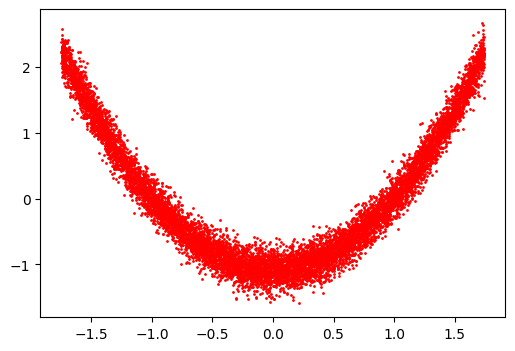

In [272]:
n_samples = 10000

x = torch.empty(n_samples).uniform_(-10, 10)
noise = torch.randn(n_samples) * 5.0
y = x**2 + noise

X = torch.stack([x,y], dim=1)
X = (X - X.mean(0)) / X.std(0).clamp_min(1e-6)

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=1, c="red")

In [273]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X)
batch_size = 16

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [274]:
vae = VAE(
    input_dim=2,
    latent_dim=16,
    output_dim=2
)

optimiser = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [275]:
def train(model, optimiser, dataloader, n_epochs):
    model.train()

    count = 0
    for epoch in range(n_epochs):

        epoch_loss_total = 0
        epoch_recon = 0
        epoch_kl = 0

        for (batch,) in dataloader:
            optimiser.zero_grad()

            mu_phi, logvar_phi, mu_theta, logvar_theta = model(batch)
            
            recon = recon_term(batch, mu_theta, logvar_theta)
            kl = kl_term(mu_phi, logvar_phi)

            loss = -(recon-kl)
            loss.backward()
            optimiser.step()

            epoch_loss_total += loss.item()
            epoch_recon += recon.item()
            epoch_kl += kl.item()

        count += 1 
        
        print(
            f"Epoch {count}/{n_epochs} || Loss: {epoch_loss_total / count:.4f} "
            f"|| Recon: {epoch_recon / count:.4f} || KL: {epoch_kl / count:.4f}"
        )
        

In [276]:
@torch.no_grad()
def sample(model, n_samples: int = 1000):
    model.eval()
    latent_dim = model.encoder.fc_mean.out_features

    z = torch.randn(n_samples, latent_dim)
    mu_theta, logvar_theta = model.decoder(z)

    sigma = torch.exp(0.5 * logvar_theta)
    epsilon = torch.randn_like(mu_theta)

    x = mu_theta + sigma * epsilon

    return x

In [279]:
train(
    model=vae,
    optimiser=optimiser,
    dataloader=loader,
    n_epochs=100
)

Epoch 1/100 || Loss: -1077.4132 || Recon: 1695.7213 || KL: 618.3081
Epoch 2/100 || Loss: -537.3544 || Recon: 844.6523 || KL: 307.2979
Epoch 3/100 || Loss: -358.5592 || Recon: 563.7766 || KL: 205.2174
Epoch 4/100 || Loss: -268.5478 || Recon: 422.8481 || KL: 154.3003
Epoch 5/100 || Loss: -209.9451 || Recon: 332.2126 || KL: 122.2674
Epoch 6/100 || Loss: -178.3171 || Recon: 280.7475 || KL: 102.4304
Epoch 7/100 || Loss: -154.0873 || Recon: 242.2641 || KL: 88.1768
Epoch 8/100 || Loss: -137.6567 || Recon: 215.6572 || KL: 78.0005
Epoch 9/100 || Loss: -120.4441 || Recon: 189.6697 || KL: 69.2257
Epoch 10/100 || Loss: -108.5486 || Recon: 170.8116 || KL: 62.2629
Epoch 11/100 || Loss: -100.1829 || Recon: 156.9774 || KL: 56.7945
Epoch 12/100 || Loss: -91.4549 || Recon: 143.5449 || KL: 52.0900
Epoch 13/100 || Loss: -82.9431 || Recon: 130.6686 || KL: 47.7255
Epoch 14/100 || Loss: -78.0133 || Recon: 122.2071 || KL: 44.1938
Epoch 15/100 || Loss: -73.5136 || Recon: 115.0650 || KL: 41.5514
Epoch 16/100 ||

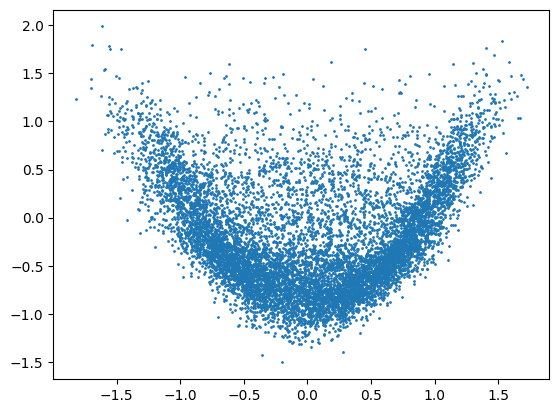

In [278]:
samples = sample(vae, n_samples=10000)

plt.scatter(samples[:,0], samples[:,1], s=1)
